# Bayesian MBG estimation

## Geostatistical Modeling

In [77]:
import pymc as pm
#import aesara.tensor as at
#from aesara.graph.basic import Constant
import os
import pickle
import numpy as np
import arviz as az
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at
import functions

import uuid

In [78]:
# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 10


### Parameters

In [79]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [80]:
report

{'Country': 'KHM',
 'DHS survey year': 2005,
 'Target Indicator': 'rate_nutr',
 'Urban-rural threshold': 25,
 'Covariates before filtering': 81,
 'Variogram Range': np.float64(0.2562914034453799),
 'Suggested ls beta': 2.0,
 'Covariates after square and square-root transforms': 67,
 'Covariates after pairwise interactions': 2278,
 'Target mean pre transform': np.float64(0.37988868077513227),
 'Target std pre transform': np.float64(0.17326739454356768),
 'Transformation Applied': 'none',
 'Lambda': None,
 'Number of covariates selected after Lasso': 8}

In [81]:
target_indicator = report['Target Indicator']

In [82]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

### Load the target and the covariates

In [83]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')

In [84]:
# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for unobserved rows
coordinates_unobserved = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[gdf[target_indicator].isnull()].geometry])

In [85]:
#Drop geometry
df = gdf.drop('geometry', axis=1)

In [86]:
#Only rows with observed target indicator
df1 = df[~df[target_indicator].isnull()]

In [87]:
#Save sampled df1 for next notebook
with open('temp_files/report/df1_sample.pkl', 'wb') as pickle_file:
    pickle.dump(df1, pickle_file)

### Transform the target indicator

In [88]:
## Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

## Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

## Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

Skewness: 0.3935230753358205, Kurtosis: -0.044305710081624206
No transformation applied due to low skewness and non-positive values.


/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_28482/538854860.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[target_indicator] = target_transformed


In [89]:
selected_features = df1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'PHUMCODE']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [90]:
# Covariate matrix
X = df1[selected_features].values

# Series with the target variable observed
response = df1[target_indicator].values

In [91]:
#Store the mean and the std for inverse transformation
report['Target mean'] = response.mean()
report['Target std'] = response.std()

In [92]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [93]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaler_y = StandardScaler()
response = scaler_y.fit_transform(response.reshape(-1, 1)).flatten()

In [94]:
#Standarize the coordinates
# Initialize the StandardScaler
scaler_coordinates = StandardScaler()

# Standardize the coordinates
coordinates_observed = scaler_coordinates.fit_transform(coordinates_observed)

In [95]:
report['Observations used to train the model'] = response.shape[0]

### Bayesian Model Training

Key Components of the Model

    Priors:
        beta: Coefficients for the linear model, assumed to follow a normal distribution with mean 0 and standard deviation 1.
        sigma: Standard deviation of the observation noise, assumed to follow a half-normal distribution with standard deviation 1.
        ls: Length-scale parameter for the spatial covariance function, assumed to follow a half-Cauchy distribution with scale parameter 1.

    Spatial Distance Matrix:
        D: Matrix of Euclidean distances between all pairs of observed locations.

    Covariance Function:
        K: Covariance function (Matern 5/2) which defines the spatial correlation structure.

    Gaussian Process (GP):
        gp: Latent Gaussian process with the defined covariance function.
        f: Prior distribution of the GP evaluated at the observed coordinates.

    Linear Model:
        mu: Mean of the linear model which is a combination of the linear predictor (X * beta) and the spatial effect (f).
        y_obs: Observed responses, modeled as a normal distribution with mean mu and standard deviation sigma.

    Inference:
        Using Automatic Differentiation Variational Inference (ADVI) to approximate the posterior distribution of the model parameters.
        advi_fit: Fitting the model using ADVI.
        trace: Sampling from the fitted model to obtain posterior samples.

In [96]:
print(f'Observations to train on {response.shape[0]}')

Observations to train on 293


In [97]:
report['Variogram Range']

np.float64(0.2562914034453799)

In [98]:
%%time
# Fit a Bayesian geostatistical model
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=report['Target mean'], sigma=report['Target std'], shape=len(selected_features))
    #beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    #sigma = pm.HalfNormal('sigma', sigma=report['Target std'])
    sigma = pm.HalfNormal('sigma', sigma=1)
    
   #ls = pm.HalfCauchy('ls', beta=report['Suggested ls beta'])

    ls = pm.HalfCauchy('ls', beta=report['Variogram Range'])

    print('Priors run')

    # Spatial distance matrix
    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    print('Distance matrix calculated')

    # Define covariance function
    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    print('Covariance run')

    # Linear model
    ## This defines the mean of the normal distribution for the observed data. It combines a linear regression term (pm.math.dot(X, beta)) with the GP latent function f.
    mu = pm.math.dot(X, beta) + f

    ## This defines the likelihood of the observed data (response) as a normal distribution with mean mu and standard deviation sigma.
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

    print('Linear model specified')

    # Inference
    step = pm.NUTS(target_accept=0.95)
    idata = pm.sample(100, tune=100, step=step, cores=num_cores, return_inferencedata=True) #The num_cores parameter maxes the machine out. Tweak if needed. 

    print('Model Fitted')


Priors run
Distance matrix calculated
Covariance run
Linear model specified


Multiprocess sampling (10 chains in 10 jobs)
NUTS: [beta, sigma, ls, f_rotated_]


Output()

Sampling 10 chains for 100 tune and 100 draw iterations (1_000 + 1_000 draws total) took 622 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model Fitted
CPU times: user 1min 53s, sys: 12.5 s, total: 2min 6s
Wall time: 10min 32s


In [99]:
#az.to_netcdf(idata, trace_filename)

## Testing the model results

1. Posterior Predictive Checks
2. Prediction Accuracy Metrics
3. Residual Analysis
4. Uncertainty Quantification

### Posterior Predictive Checks:

Posterior Predictive Distribution: Compare the observed data to the posterior predictive distribution of the model. This involves generating new data based on the posterior distributions of the model parameters and comparing these simulated data to the actual observations.


Sampling: [y_obs]


Output()

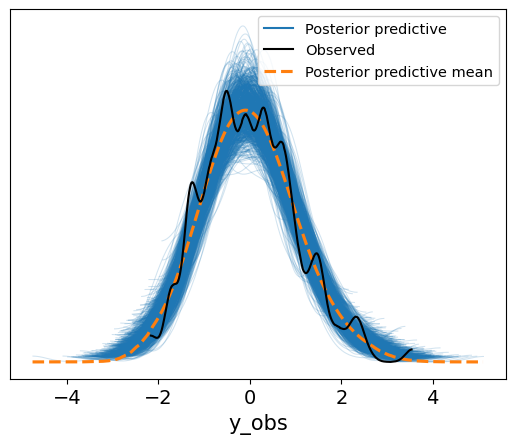

In [100]:
# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(posterior_predictive, kind='kde', data_pairs={'y_obs': 'y_obs'})

# Show the plot
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

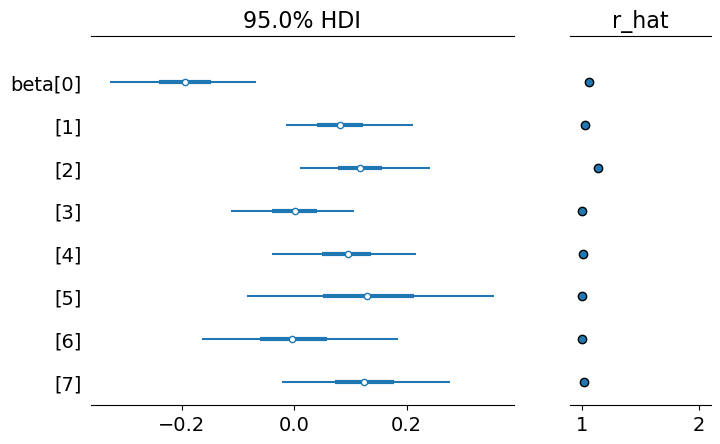

In [101]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

#### Trace plots

Interpretation of Trace Plots

    Density Plots (Left Column):
        Each subplot on the left shows the kernel density estimate of the posterior distribution for a parameter.
        These plots give an idea of the central tendency (mean or median) and the spread (variance) of the parameter estimates.
        For example, the density plot for beta shows multiple colored curves corresponding to different chains, indicating the posterior distributions of the coefficients.

    Trace Plots (Right Column):
        Each subplot on the right shows the sampled values of the parameter across iterations for each chain.
        These plots help in assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling.
        A good trace plot should look like a "hairy caterpillar," with the chains mixing well and no apparent trends or patterns over iterations.

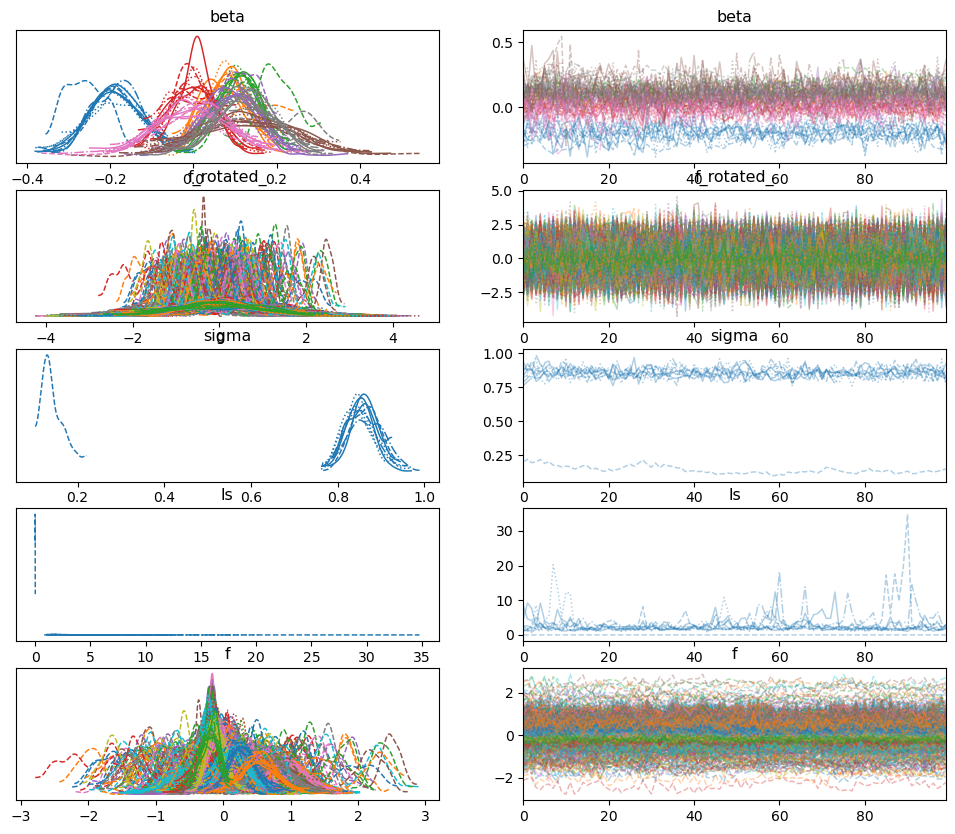

In [102]:
import matplotlib.pyplot as plt

# Generate the trace plot
trace_plot = az.plot_trace(idata)

# Save the plot to a file
plt.savefig('temp_files/report/9. trace_plot.pdf')

### Residual Analysis

#### Spatial Residual Plots 

Plot residuals (the differences between observed and predicted values) over the spatial domain to check for patterns. Randomly distributed residuals indicate a good fit.

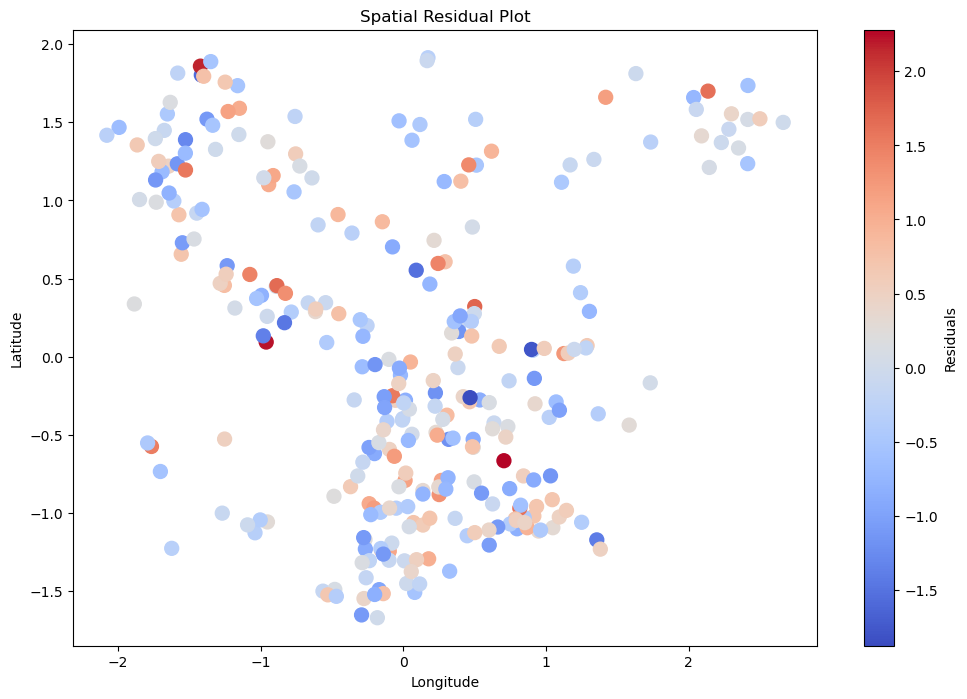

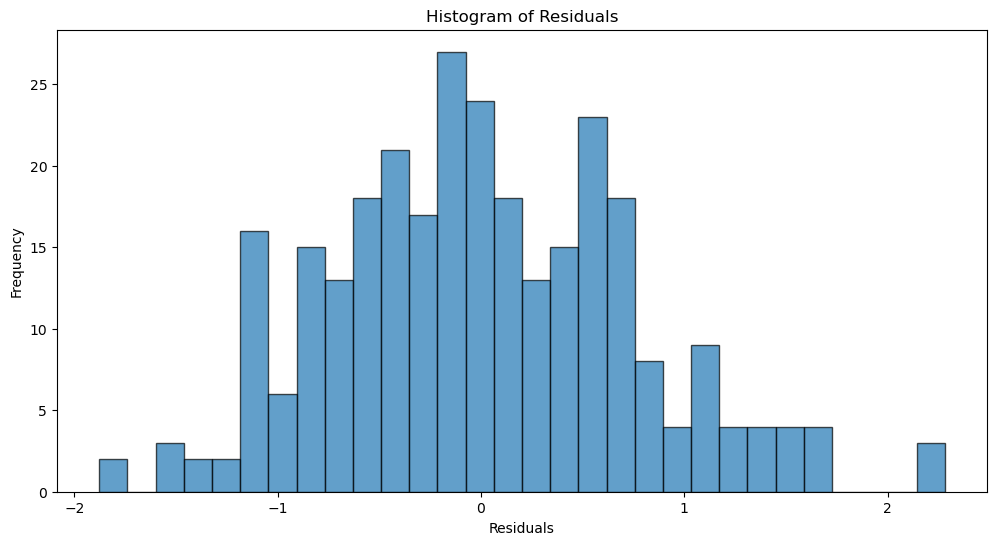

In [103]:
# Extract the observed data
y_obs = posterior_predictive.observed_data['y_obs'].values

# Calculate the mean of the simulated data across chains and draws
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=('chain', 'draw')).values

# Calculate residuals
residuals = y_obs - y_sim

# Plot spatial residuals
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_observed[:, 0], coordinates_observed[:, 1], c=residuals, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Uncertainty Quantification

	•	Credible Intervals: Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.
	•	Uncertainty Maps: Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Sampling: [y_obs]


Output()

Coverage of 95% Credible Intervals: 100.00%


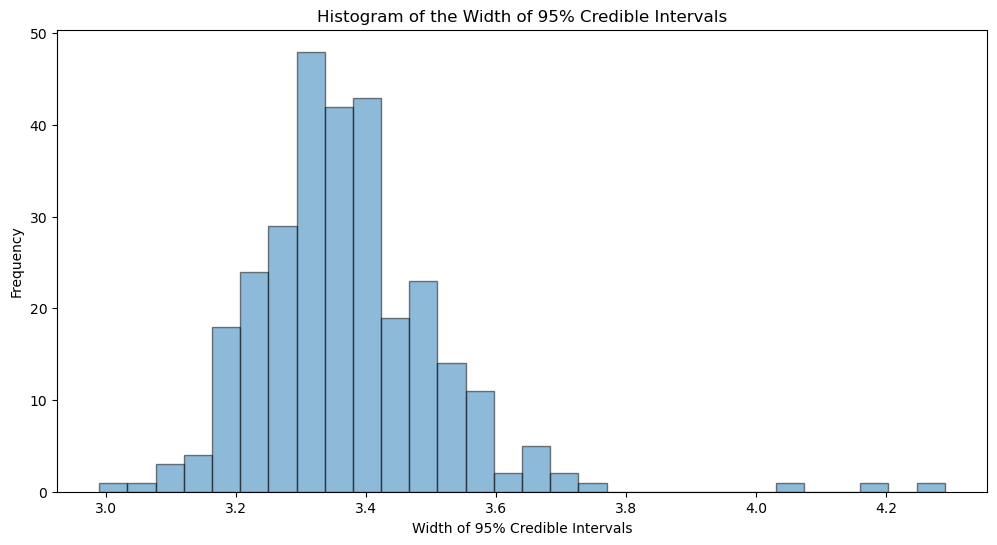

In [104]:
# Extract the observed and simulated data
y_obs = response

# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Extract the mean prediction, lower and upper bounds of the 95% credible intervals
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain", "draw")).values
hdi = az.hdi(posterior_predictive.posterior_predictive, hdi_prob=0.95)['y_obs']

# Calculate the width of the credible intervals
ci_width = hdi[:, 1] - hdi[:, 0]

# Check how many true values are within the credible intervals
within_ci = np.sum((y_obs >= hdi[:, 0]) & (y_obs <= hdi[:, 1]))
total_obs = len(y_obs)
coverage = within_ci / total_obs

print(f"Coverage of 95% Credible Intervals: {coverage * 100:.2f}%")



# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.5)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals')
plt.show()

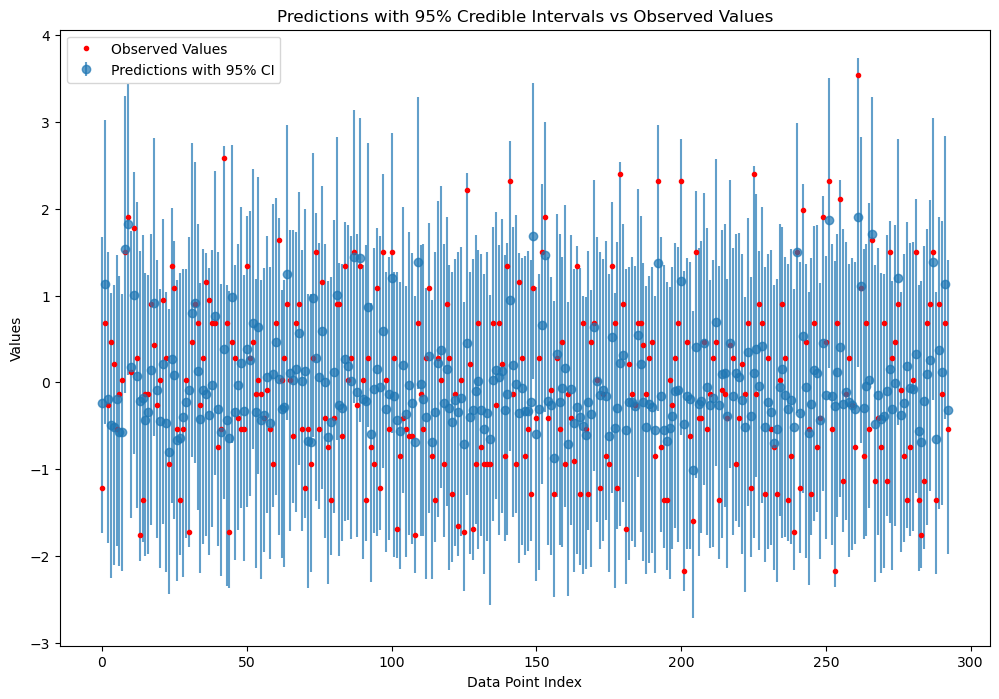

In [105]:
# Plot the credible intervals vs the observed values
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(y_obs)), y_sim, yerr=[y_sim - hdi[:, 0], hdi[:, 1] - y_sim], fmt='o', alpha=0.7, label='Predictions with 95% CI')
plt.plot(np.arange(len(y_obs)), y_obs, 'r.', label='Observed Values')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predictions with 95% Credible Intervals vs Observed Values')
plt.legend()
plt.show()

### Transform the results back to original scale

#### Revert observed

In [106]:
y_denormalized = functions.revert_standardization(response, report['Target mean'], report['Target std'])

In [107]:
y_original_scale = functions.revert_transformation(y_denormalized, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

#### Revert predicted

In [108]:
y_sim_dn = functions.revert_standardization(y_sim, report['Target mean'], report['Target std'])

In [109]:
y_sim_original_scale = functions.revert_transformation(y_sim_dn, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

### Prediction Accuracy Metrics (at original scale)

#### Mean Absolute Error (MAE)

Measures the average magnitude of the errors in a set of predictions, without considering their direction.

In [110]:
# Calculate the absolute errors
absolute_errors = np.abs(y_original_scale - y_sim_original_scale)

# Calculate the Mean Absolute Error
mae = np.mean(absolute_errors)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.10465733788395905


In [111]:
report['Bayesian model MAE'] = mae

#### Root Mean Squared Error (RMSE) 

Measures the square root of the average of squared differences between predicted and observed values, providing an indication of the model’s overall error.

In [112]:
# Calculate the squared errors
squared_errors = np.square(y_original_scale - y_sim_original_scale)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.1309009750000843


In [113]:
report['Bayesian RMSE'] = rmse

In [114]:
#Save report as pickle
with open('temp_files/report/report.pkl', 'wb') as pickle_file:
    pickle.dump(report, pickle_file)

In [115]:
bayesian_report_keys = ['Variogram Range',
                        'Transformation Applied', 
                        'Number of covariates selected after Lasso',  
                        'Observations used to train the model',
                        'Target mean', 
                        'Target std',
                        'Target mean pre transform',
                        'Target std pre transform',
                        'Bayesian model MAE', 
                        'Bayesian RMSE']

In [116]:
bayesian_report = {key: report[key] for key in bayesian_report_keys if key in report}

In [117]:
t1 = pd.DataFrame(data={'Data':bayesian_report.keys(), 
                  'Value': bayesian_report.values()}, 
             columns=['Data','Value'])

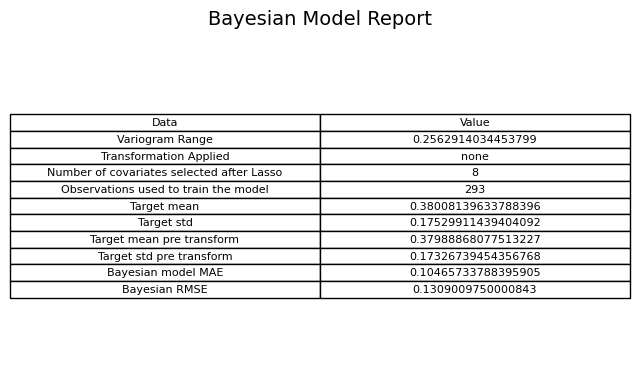

In [118]:
table_path = os.path.join('temp_files/report/', '14. Bayesian Report.pdf')
title = 'Bayesian Model Report'
functions.df_to_pdf(t1, table_path, title=title, show=True)

# Predictions

In [119]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')
gdf_full = pd.read_pickle('temp_files/selected_features_full.pkl')

In [120]:
selected_features = gdf.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'PHUMCODE']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [121]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

#Standardize
coordinates = scaler.fit_transform(coordinates)

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Standardize
coordinates_observed = scaler.fit_transform(coordinates_observed)

In [122]:
#Only rows with observed target indicator
df1 = gdf[~gdf[target_indicator].isnull()]

In [123]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: 0.3935230753358205, Kurtosis: -0.044305710081624206
No transformation applied due to low skewness and non-positive values.


In [124]:
#Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [125]:
# Transformed target variable
y = df1[target_indicator].values

In [126]:
# Covariate matrix
X = df1[selected_features].values

In [127]:
# Standardize features and transformed y

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [128]:
# Save the scaler to a pickle file
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [129]:
#DF with all observations
gdf2 = gdf_full.copy(deep=True) #This line to make predictions for all observations
#gdf2 = gdf2.sample(1000)
df2 = gdf2.copy(deep=True)
df2.reset_index(drop=True, inplace=True)

# Extract coordinates from the geometry column (using centroid for Pcolygons)
coordinates_new = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf2.geometry])

# Standardize
coordinates_new = scaler.fit_transform(coordinates_new)

# Covariate matrix
X_new = df2[selected_features].values

# Standardize the new data using the same scaler fitted on the observed data
X_new = scaler_x.transform(X_new)

In [130]:
begin_from_scratch = True
    
if begin_from_scratch == True: 
    #Dataframe to store predictions and other values for uncertainty calculations
    df3 = pd.DataFrame(df2[['PHUMCODE', target_indicator]].head(0))
    start_position=0

else:
    #Pick-up productions were we left of. 
    with open('temp_files/predictions.pkl', 'rb') as pickle_file:
        df3 = pickle.load(pickle_file)
    start_position = df3.index.max() + 1

In [131]:
import scipy.stats as stats

In [132]:
# Assuming 95% confidence level, change alpha for different confidence levels
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha/2)

In [133]:
step = 20

In [134]:
X_new.shape

(12076, 8)

In [135]:
# Step is the number of observations to select in each iteration
num_observations = len(X_new)
all_indices = np.arange(num_observations)

for i in range(start_position, num_observations, step):
    
    # Randomly select 'step' indices without replacement for each iteration
    if step <= len(all_indices):
        r = np.random.choice(all_indices, size=step, replace=False)
        all_indices = np.setdiff1d(all_indices, r)  # Remove the selected indices from the pool
    else:
        # If fewer than 'step' indices remain, select all remaining indices
        r = all_indices
        all_indices = np.array([])

    print(f"Remaining indices: {len(all_indices)}")

    # Select the subset of new data points for this batch
    X_new_i = X_new[r]
    coordinates_new_i = coordinates_new[r]

    # Generate a unique variable name for each iteration
    f_pred_name = "f_pred_" + str(uuid.uuid4())

    # Prediction generation using the Gaussian Process and posterior sampling
    with model:
        # Define the Gaussian Process covariance function for new points with jitter for numerical stability
        f_pred = gp.conditional(f_pred_name, Xnew=coordinates_new_i, jitter=1e-3)
    
        # Sampling from the posterior predictive distribution for the new data points
        ppc = pm.sample_posterior_predictive(idata, var_names=[f_pred_name], return_inferencedata=True)

    # Extract 'beta' samples from the original posterior (idata)
    beta_samples = idata.posterior['beta'].values  # Posterior samples for 'beta'

    # Extract GP samples from posterior predictive
    gp_samples = ppc.posterior_predictive[f_pred_name].values  # GP predictions

    # Check dimensions
    print(f"beta_samples shape: {beta_samples.shape}")  # Should be (num_samples, num_features)
    print(f"X_new_i shape: {X_new_i.shape}")            # Should be (num_points, num_features)

    # Calculate the linear component (dot product) for each sample
    # Make sure the dimensions match: (num_samples, num_features) @ (num_features, num_points)
    linear_component = np.dot(beta_samples, X_new_i.T)  # Shape: (num_samples, num_points)

    # Combine the GP predictions and linear component
    combined_predictions = gp_samples + linear_component

    # Create DataFrame for all posterior samples (1000 samples for each observation)
    dfpi = pd.DataFrame(combined_predictions.mean(axis=0))  # The shape should be (1000, num_points)

    # Extracting relevant data for the current batch
    dfi = df2.loc[r][['PHUMCODE', target_indicator]]

    # Combine predictions with the data
    dfi[target_indicator] = dfpi.mean(axis=0).values  # Mean prediction across samples
    dfi['std'] = dfpi.std(axis=0).values               # Standard deviation across samples
    dfi['max'] = dfpi.max(axis=0).values               # Max prediction across samples
    dfi['min'] = dfpi.min(axis=0).values               # Min prediction across samples

    # Calculating the margin of error for the confidence interval
    dfi['standard_error'] = dfi['std'] / (len(dfpi)**0.5)
    dfi['margin_of_error'] = z_score * dfi['standard_error']

    # Calculating the confidence interval
    dfi['ci_lower'] = dfi[target_indicator] - dfi['margin_of_error']
    dfi['ci_upper'] = dfi[target_indicator] + dfi['margin_of_error']

    # Combine with previous results
    df3 = pd.concat([df3, dfi])

    # Save predictions so far
    dfpi.to_pickle('temp_files/dfpi.pkl')  # Save all predictions for the current batch
    df3.to_pickle('temp_files/predictions.pkl')

    # Break the loop if no more indices are left to process
    if len(all_indices) == 0:
        break


Remaining indices: 12056


Sampling: [f_pred_bd58fe20-7c0d-4047-9492-552d868b5c7e]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 12036


Sampling: [f_pred_cc7cd979-38c5-452e-b8eb-9e543b42f962]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 12016


Sampling: [f_pred_582e8427-ed45-4855-b033-cc777242e1b7]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11996


Sampling: [f_pred_86df6414-1a1c-4396-99c1-4edc588efc2c]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11976


Sampling: [f_pred_f1d0a8a1-e84e-4584-b38f-57ea0c4d698c]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11956


Sampling: [f_pred_2e7e2269-a207-4dc8-92be-6baa68405dfa]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11936


Sampling: [f_pred_9ffb71fb-7c8d-4b8f-9e1a-c213172f7917]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11916


Sampling: [f_pred_063929ef-2479-4bca-a9fd-5c6a99fd0603]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11896


Sampling: [f_pred_a49117b2-0633-46b3-8c0d-fec58b9c051c]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11876


Sampling: [f_pred_e393e2d9-393d-4ece-9844-b28ea72d8d27]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11856


Sampling: [f_pred_6cd77d9d-8e89-4393-a9b8-3da9aa5e27bc]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11836


Sampling: [f_pred_ffad37e8-4e63-4352-85fb-73837c4bf7d0]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11816


Sampling: [f_pred_ff5b373a-ef60-4b3e-b6f6-95f58d2a3fa0]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11796


Sampling: [f_pred_3c56da4b-57d0-462c-9919-f815f6898aa6]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11776


Sampling: [f_pred_20981bd3-94f1-4284-9b7a-11b1c3aa5065]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11756


Sampling: [f_pred_d5309bb8-9a55-40b2-98dc-3c8f5b45e69e]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11736


Sampling: [f_pred_1a5cfd40-49c7-45b0-a3f1-d681412d2f61]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11716


Sampling: [f_pred_e0600b0f-d466-45ff-bee1-95958e44abe5]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11696


Sampling: [f_pred_4051ee1c-24d7-4c95-b276-aeae6a92cfff]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11676


Sampling: [f_pred_c42106de-6fc5-4910-ba2d-bf994c40270b]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11656


Sampling: [f_pred_c5bd3c58-1a32-4c2d-bebf-bc68b2896fc8]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11636


Sampling: [f_pred_5e266322-d693-4f0a-b45a-51bbe92a2cfa]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11616


Sampling: [f_pred_5e7e1c0a-39e2-42ef-a386-995d302a0367]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11596


Sampling: [f_pred_602292a9-d19e-45dd-befe-4e9356e66c58]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11576


Sampling: [f_pred_bb013d21-8332-46f7-b2d6-272928d5319f]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11556


Sampling: [f_pred_b1d9a2db-6857-45a9-8624-2bfbfd610644]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11536


Sampling: [f_pred_0d8bba76-241b-4a2a-88f0-826903f6b58b]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11516


Sampling: [f_pred_84bb1dd8-fba0-47d2-851a-a934d5ccdb7b]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11496


Sampling: [f_pred_9a40b755-4099-4eb4-b5e2-d9d78b702fc8]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11476


Sampling: [f_pred_c18156b7-ece9-4410-9faf-430190525cd1]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11456


Sampling: [f_pred_2ac17e12-a828-43b3-a18c-16ea30062c72]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11436


Sampling: [f_pred_9fc0a888-372a-49fd-9536-e7394fd88af4]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11416


Sampling: [f_pred_3d087efb-912c-4f0e-be42-67b99b6f64a0]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11396


Sampling: [f_pred_85e669db-8c52-4718-a9d7-055d6283eef6]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11376


Sampling: [f_pred_95b87bad-ad5b-4900-ab28-aa3fe3257059]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11356


Sampling: [f_pred_4ac67a25-3ec9-410c-92f5-12ce0e7e0179]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11336


Sampling: [f_pred_8b9b794a-bb12-4e3a-9137-185dc8c99c27]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11316


Sampling: [f_pred_c8d4d654-7311-4af3-aa77-bae30e9cf1cc]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11296


Sampling: [f_pred_4bf6f362-c5c1-4ea5-bed9-5653f1ec24f9]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11276


Sampling: [f_pred_1352c90a-8ca7-458c-8545-3c7343c5f2a9]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11256


Sampling: [f_pred_dd3a818e-8e35-4ea5-a51a-27db99affcc5]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11236


Sampling: [f_pred_cfe8ab52-4a42-498b-9d25-411ed474df9f]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11216


Sampling: [f_pred_772fc764-c42f-4396-ac63-e220e6ff2bff]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11196


Sampling: [f_pred_864e074c-be8f-4c60-bc4c-c14c77f611ac]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11176


Sampling: [f_pred_59be5c4b-dbb5-4a67-af6e-63af576ec7fc]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11156


Sampling: [f_pred_3c49a7f0-1ad8-4718-8aaf-804037b08468]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11136


Sampling: [f_pred_b0c91e01-2f95-4989-8ee9-e46c95065a29]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11116


Sampling: [f_pred_e5a9816e-2bad-4c19-9ddc-ce9dc18d4edd]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11096


Sampling: [f_pred_a5e9ce1a-2951-4ab8-aec1-5a94a615bd31]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11076


Sampling: [f_pred_9584435d-3b3d-4b86-b22b-f3f25a110ae4]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11056


Sampling: [f_pred_a8d41965-63f3-45cc-8fc9-f2dd08fbc22b]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11036


Sampling: [f_pred_654f6982-bc2b-4758-a58b-36607ea53ad1]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 11016


Sampling: [f_pred_5fb18ef9-1456-456d-a073-a1b350e47aeb]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10996


Sampling: [f_pred_55628c42-911f-4f18-b28b-98bd38c21438]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10976


Sampling: [f_pred_7267cb3b-8abf-438d-aaee-541534b90a51]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10956


Sampling: [f_pred_979b0ed8-2fc1-4c7e-93f1-1718c4b687e8]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10936


Sampling: [f_pred_b4daeb63-97af-41aa-854a-f3ef12531623]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10916


Sampling: [f_pred_f1d5ef69-5e1c-4b1f-98a7-ffd8e5c0bd57]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10896


Sampling: [f_pred_a6cc3f15-40ca-4be9-8203-0d71be3dafad]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10876


Sampling: [f_pred_69afc429-d1e1-4063-9ae9-af5b10874833]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10856


Sampling: [f_pred_6dc8d3f5-5b0c-433d-a084-b6f2a07ec8a0]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10836


Sampling: [f_pred_7b01ac8b-ab67-4f8a-9a6d-d7a2c3138d6e]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10816


Sampling: [f_pred_697821a7-9099-4e66-bd35-369ea0b08482]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10796


Sampling: [f_pred_1c8ed06b-8f84-416a-8837-c40047fa80bc]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10776


Sampling: [f_pred_a3a33ce9-370d-42bd-b591-3d6a7394f7e3]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10756


Sampling: [f_pred_71e29637-f14a-49b1-b8e7-3f6149a31686]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10736


Sampling: [f_pred_ab2f4d7e-3687-472c-ba40-f005c9d308b8]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10716


Sampling: [f_pred_4cbcbc63-a7b9-43c5-b35d-71041f11beb6]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10696


Sampling: [f_pred_79dac530-2d96-40bf-9a42-48136f039ec7]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10676


Sampling: [f_pred_3e90059a-5d8f-4d35-89ca-4e0adb5b0bca]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10656


Sampling: [f_pred_ada1b9fd-1b9c-4837-a1f1-04b5ab9ed536]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10636


Sampling: [f_pred_6dd8902f-d027-4dea-aaf9-c1924f1042ee]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10616


Sampling: [f_pred_1e97ff6f-d233-4ce1-b341-795311ecd855]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10596


Sampling: [f_pred_b00b5550-7f4c-4cfc-9b8b-62a13830e56e]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10576


Sampling: [f_pred_c3d5338a-3ac9-4231-bb03-ada58476c933]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10556


Sampling: [f_pred_c3f3df9a-a28b-4d86-95af-8d0b468f8282]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10536


Sampling: [f_pred_d4772a85-da9c-4f76-8987-f15be3874eda]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10516


Sampling: [f_pred_75938faf-57e1-4081-bb6d-1e5388512df6]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10496


Sampling: [f_pred_5ded0737-2619-4496-a662-3ed4b8dbed0c]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10476


Sampling: [f_pred_d0b41c55-41f3-4bcd-bed7-cf2611a8d598]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10456


Sampling: [f_pred_c07bdf8f-9741-4586-b777-c4cb66a2d8b2]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10436


Sampling: [f_pred_f8da832f-0a7c-4cd2-ba0a-5388ae3688d8]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10416


Sampling: [f_pred_b6cce5ea-ef98-4e87-b561-c0e3c72588e9]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10396


Sampling: [f_pred_06ec61e6-6f8e-451e-a827-81c0772cf304]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10376


Sampling: [f_pred_9692849c-86f9-4f2b-af5f-2bf0ed6509cf]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10356


Sampling: [f_pred_f6f14bf3-6550-4a6f-b52a-15326c27f020]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10336


Sampling: [f_pred_776245aa-858b-4785-aed8-d9a7475602aa]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10316


Sampling: [f_pred_7f494f80-de63-4630-b357-10b686a102b4]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10296


Sampling: [f_pred_ee58ada6-6d11-4468-82a3-484ef13f8037]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10276


Sampling: [f_pred_58e9a966-19bb-4ddb-a9cd-3a428453451a]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10256


Sampling: [f_pred_1fa04dff-6ced-460d-b50c-83c5a4f138d2]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10236


Sampling: [f_pred_bdce29ae-8d8d-4a76-9d6b-43af2134a67f]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10216


Sampling: [f_pred_efa5aa50-760e-4e38-ae98-f5d4a2f36f6a]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10196


Sampling: [f_pred_0869bbcf-f3f7-42d0-b4bf-912a32bbecb9]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10176


Sampling: [f_pred_c6002481-150a-45bd-9161-f008f0bacf32]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10156


Sampling: [f_pred_10ed857f-0d69-4104-bb98-eda87ce50522]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10136


Sampling: [f_pred_abdf6cbe-28bc-4126-9e36-7b6d2f263701]


Output()

beta_samples shape: (10, 100, 8)
X_new_i shape: (20, 8)
Remaining indices: 10116


Sampling: [f_pred_c44d18c0-f1f2-4276-9ea6-dc29a3814e81]


Output()

LinAlgError: Matrix is not positive definite
Apply node that caused the error: MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=True, method='cholesky'}(RNG(<Generator(PCG64) at 0x36DF2A880>), NoneConst{None}, CGemv{inplace}.0, Gemm{inplace}.0)
Toposort index: 25
Inputs types: [RandomGeneratorType, <pytensor.tensor.type_other.NoneTypeT object at 0x11efea270>, TensorType(float64, shape=(20,)), TensorType(float64, shape=(20, 20))]
Inputs shapes: ['No shapes', 'No shapes', (20,), (20, 20)]
Inputs strides: ['No strides', 'No strides', (8,), (160, 8)]
Inputs values: [Generator(PCG64) at 0x36DF2A880, None, 'not shown', 'not shown']
Outputs clients: [[output[1](MvNormalRV{name='multivariate_normal', signature='(n),(n,n)->(n)', dtype='float64', inplace=True, method='cholesky'}.0)], [output[0](f_pred_c44d18c0-f1f2-4276-9ea6-dc29a3814e81)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_28482/1773184227.py", line 28, in <module>
    f_pred = gp.conditional(f_pred_name, Xnew=coordinates_new_i, jitter=1e-3)
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/gp/gp.py", line 284, in conditional
    f = pm.MvNormal(name, mu=mu, cov=cov, **kwargs)
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/distributions/distribution.py", line 505, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/distributions/multivariate.py", line 272, in dist
    return super().dist([mu, cov], **kwargs)
  File "/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/distributions/distribution.py", line 574, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

## Covariate Coefficients Analysis

In [ ]:
# Extract the posterior distribution for beta
beta_posterior = idata.posterior['beta']

# Compute the mean and 94% highest posterior density (HPD) intervals
beta_mean = beta_posterior.mean(dim=["chain", "draw"])
beta_hpd = pm.hdi(beta_posterior, hdi_prob=0.94)

# Display the results
print("Covariate Coefficients (Beta):")
print("Posterior Mean:\n", beta_mean)
print("94% HPD Interval:\n", beta_hpd)

In [ ]:
t9 = pd.DataFrame([selected_features, beta_mean.values]).transpose()

In [ ]:
t9.columns = ['Covariate', 'Coefficient (standardized)']

In [ ]:
t9['Coefficient (standardized)'] = t9['Coefficient (standardized)'].astype(float).round(4)

In [ ]:
table_path = os.path.join('temp_files/report/', '15. Bayesian Coefficients.pdf')
title = 'Bayesian Model Coefficients'
functions.df_to_pdf(t9, table_path, title=title, show=True)